### **기본 세팅**
---

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [238]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install tqdm
!pip install catboost
!pip install category_encoders

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded
     |████████████████████████████████| 80

In [4]:
import sys
import math
import random

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

from matplotlib import font_manager, rc
rc('font', family='NanumBarunGothic') 

seed = 0

data_path = "/content/drive/Shareddrives/Parking_pred/data/Encoded/"
result_path = "/content/drive/Shareddrives/Parking_pred/jihoon/result/"
result_file = "cat_baseline.csv"

train = pd.read_excel(data_path + "train.xlsx")
test = pd.read_excel(data_path + "test.xlsx")
age_gender = pd.read_excel(data_path + "age_gender_info.xlsx")

submission = pd.read_excel(data_path + "sample_submission.xlsx")

train.shape, test.shape

((2952, 15), (1022, 14))

### **오류 데이터 처리**
---

In [5]:
train_code = ['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
test_code = ['C2335', 'C1327']
submission_code = ['C2335', 'C1327', 'C2675']
for c in train_code:
    train = train[train['단지코드'] != c]

# for c in test_code:
#     test = test[test['단지코드'] != c]

# for c in submission_code:
#     submission = submission[submission['code'] != c]

train.shape, test.shape, submission.shape

((2896, 15), (1022, 14), (150, 2))

In [6]:
c2085 = train[train['단지코드'] == 'C2085'].index
train.loc[c2085, '단지코드'] = 'C1397'

c1397 = train[train['단지코드'] == 'C1397'].index
train.loc[c1397, '총세대수'] = 1339

In [7]:
c2461 = train[train['단지코드'] == 'C2431'].index
train.loc[c2461, '단지코드'] = 'C1649'

c1649 = train[train['단지코드'] == 'C1649'].index
train.loc[c1649, '총세대수'] = 1047
train.loc[c1649, '등록차량수'] = 1214

In [8]:
c2675 = test[test['단지코드'] == 'C2675']
c2675['등록차량수'] = 1279
c2675['단지코드'] = 'C1036'
c2675

# test = test[test['단지코드'] != 'C2675']

train = train.append(c2675)
train = train.reset_index(drop=True)
c1036 = train[train['단지코드'] == 'C1036'].index
train.loc[c1036, '총세대수'] = 1254

test[test['단지코드'] == 'C2675'], train[train['단지코드'] == 'C1036']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(      단지코드  총세대수  ... 도보 10분거리 내 버스정류장 수 단지내주차면수
 579  C2675   512  ...                  3    1016
 580  C2675   512  ...                  3    1016
 581  C2675   512  ...                  3    1016
 582  C2675   512  ...                  3    1016
 583  C2675   512  ...                  3    1016
 584  C2675   512  ...                  3    1016
 585  C2675   512  ...                  3    1016
 586  C2675   512  ...                  3    1016
 
 [8 rows x 14 columns],
        단지코드  총세대수 임대건물구분  ... 도보 10분거리 내 버스정류장 수 단지내주차면수  등록차량수
 1490  C1036  1254    아파트  ...                3.0    1016   1279
 1491  C1036  1254    아파트  ...                3.0    1016   1279
 1492  C1036  1254    아파트  ...                3.0    1016   1279
 1493  C1036  1254    아파트  ...                3.0    1016   1279
 1494  C1036  1254    아파트  ...                3.0    1016   1279
 1495  C1036  1254    아파트  ...                3.0    1016   1279
 1496  C1036  1254    아파트  ...                3.0    1016   1279
 289

In [9]:
def get_mod_miss_households(data):
    total = data.iloc[0]['총세대수']
    sum_hh = data['전용면적별세대수'].sum()
    miss = total - sum_hh
    prop = (data['전용면적별세대수'] / sum_hh).tolist()
    miss_prop = [int(p * miss) for p in prop]
    int_miss = miss - sum(miss_prop)
    for i in range(int_miss):
        miss_prop[(i)%len(miss_prop)] += 1

    return miss_prop

total_miss = ['C1490', 'C2497', 'C2620', 'C1344', 'C1024', 'C2470', 'C1206', 'C1740', 'C2405', 'C1804',
                'C1925', 'C1312', 'C2013', 'C1424', 'C2520', 'C2319', 'C1850', 'C1068', 'C2644', 'C2156', 
                'C2453', 'C1910', 'C2139', 'C2508', 'C1695', 'C2556', 'C2362', 'C2568', 'C2245', 'C2549', 
                'C1584', 'C2298', 'C2225', 'C1218', 'C1970', 'C1732', 'C2433', 'C1894', 'C1156', 'C2142', 
                'C2186', 'C2411', 'C1812', 'C1030', 'C1749', 'C1349', 'C2043', 'C1229', 'C2363', 'C1414', 
                'C2174', 'C2404', 'C1683', 'C1038', 'C2456', 'C1266', 'C1267', 'C2189']

for tm in total_miss:
    if train[train['단지코드'] == tm].shape[0] == 0:
        if test[test['단지코드'] == tm].shape[0] == 0:
            print("Empty: {}".format(tm))
            continue
        else:
            mod = get_mod_miss_households(test[test['단지코드'] == tm])
            idx = test[test['단지코드'] == tm].index
            test.loc[idx, '전용면적별세대수'] += mod
            # print(test[test['단지코드'] == tm][["총세대수", "전용면적별세대수"]])
    else:
        mod = get_mod_miss_households(train[train['단지코드'] == tm])
        idx = train[train['단지코드'] == tm].index
        train.loc[idx, '전용면적별세대수'] += mod
        # print(train[train['단지코드'] == tm][["총세대수", "전용면적별세대수"]])

train.shape, test.shape

Empty: C1218
Empty: C1894


((2904, 15), (1022, 14))

In [10]:
train.reset_index(drop = True, inplace=True)
test.reset_index(drop = True, inplace=True)
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17,A,9216000.0,82940.0,0.0,3.0,624,205
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17,A,12672000.0,107130.0,0.0,3.0,624,205
2,C2515,545,아파트,경상남도,국민임대,39.60,20,17,A,12672000.0,107130.0,0.0,3.0,624,205
3,C2515,545,아파트,경상남도,국민임대,46.90,38,17,A,18433000.0,149760.0,0.0,3.0,624,205
4,C2515,545,아파트,경상남도,국민임대,46.90,19,17,A,18433000.0,149760.0,0.0,3.0,624,205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,C1036,1254,아파트,경기도,국민임대,46.90,50,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2900,C1036,1254,아파트,경기도,국민임대,46.90,88,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2901,C1036,1254,아파트,경기도,국민임대,47.40,30,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2902,C1036,1254,아파트,경기도,국민임대,51.93,75,9,A,43819000.0,275900.0,0.0,3.0,1016,1279


### **단지 통합**

In [372]:
tmp_train = train.copy()
tmp_test = test.copy()

tmp_train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '등록차량수'
]
tmp_test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수'
]

In [373]:
columns = ['단지코드', '총세대수', '총구성원수', '등록차량_인구통계', '임대건물구분', '지역', '공급유형', 
           '공가수', '신분', '지하철', '버스', '단지내주차면수']
cat_features = ['임대건물구분', '지역', '공급유형', '신분']
target = '등록차량수'

In [374]:
## Encode categorical features
for cf in cat_features:
    map = {}
    for i, ele in enumerate(tmp_train[cf].unique()):
        map[ele] = i
    tmp_train[cf] = tmp_train[cf].map(map)
    tmp_test[cf] = tmp_test[cf].map(map)

In [375]:
tmp_train.isnull().sum(), tmp_test.isnull().sum()

(단지코드          0
 총세대수          0
 임대건물구분        0
 지역            0
 공급유형          0
 전용면적          0
 전용면적별세대수      0
 공가수           0
 신분            0
 임대보증금       581
 임대료         590
 지하철         211
 버스            4
 단지내주차면수       0
 등록차량수         0
 dtype: int64, 단지코드          0
 총세대수          0
 임대건물구분        0
 지역            0
 공급유형          0
 전용면적          0
 전용면적별세대수      0
 공가수           0
 신분            2
 임대보증금       186
 임대료         186
 지하철          42
 버스            0
 단지내주차면수       0
 dtype: int64)

In [376]:
import statsmodels.api as sm

def display_total_parknums_summary(data, seq, fig):
    total = []
    park_nums = []
    for i, code in enumerate(data['단지코드'].unique()):
        temp = data[data['단지코드']==code]
        temp.index = range(temp.shape[0])
        total.append(temp.loc[0, "총세대수"])
        park_nums.append(temp.loc[0, "단지내주차면수"])
    regline = sm.OLS(park_nums, sm.add_constant(total)).fit().fittedvalues
    fig.add_trace( go.Scatter(x=total, y=park_nums, mode="markers", 
                              marker_color=px.colors.qualitative.Plotly[seq]), row=seq+1, col=1)
    fig.add_trace(go.Scatter(x=total, y=regline,
                            mode="lines", marker_color="black"), row=seq+1, col=1)
    fig.add_trace(go.Box(y= np.array(park_nums) / np.array(total),
                            marker_color=px.colors.qualitative.Plotly[seq]), row=seq+1, col=2)
    
fig = make_subplots(2,2, column_widths=[0.7, 0.3])
fig.update_layout(width=1000, height=1000)
display_total_parknums_summary(tmp_train, 0, fig)
display_total_parknums_summary(tmp_test, 1, fig)
fig.show()

In [377]:
tmp_train = tmp_train[tmp_train['단지내주차면수']/tmp_train['총세대수'] < 1.289]
tmp_train.reset_index(drop = True, inplace=True)
tmp_train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,신분,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
0,C2515,545,0,0,0,33.48,276,17,0,9216000.0,82940.0,0.0,3.0,624,205
1,C2515,545,0,0,0,39.60,60,17,0,12672000.0,107130.0,0.0,3.0,624,205
2,C2515,545,0,0,0,39.60,20,17,0,12672000.0,107130.0,0.0,3.0,624,205
3,C2515,545,0,0,0,46.90,38,17,0,18433000.0,149760.0,0.0,3.0,624,205
4,C2515,545,0,0,0,46.90,19,17,0,18433000.0,149760.0,0.0,3.0,624,205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,C1036,1254,0,2,0,46.90,50,9,0,34082000.0,232200.0,0.0,3.0,1016,1279
2871,C1036,1254,0,2,0,46.90,88,9,0,34082000.0,232200.0,0.0,3.0,1016,1279
2872,C1036,1254,0,2,0,47.40,30,9,0,34082000.0,232200.0,0.0,3.0,1016,1279
2873,C1036,1254,0,2,0,51.93,75,9,0,43819000.0,275900.0,0.0,3.0,1016,1279


In [378]:
tmp_train['전용면적'] = tmp_train['전용면적']//3*3
tmp_test['전용면적'] = tmp_test['전용면적']//3*3

idx = tmp_train[tmp_train['전용면적']>100].index
tmp_train.loc[idx, '전용면적'] = 100
idx = tmp_test[tmp_test['전용면적']>100].index
tmp_test.loc[idx, '전용면적'] = 100

idx = tmp_train[tmp_train['전용면적']<15].index
tmp_train.loc[idx, '전용면적'] = 15
idx = tmp_test[tmp_test['전용면적']<15].index
tmp_test.loc[idx, '전용면적'] = 15

In [379]:
au = tmp_train['전용면적'].unique()
au.sort()
areas = dict.fromkeys(au, 0)
for i, row in tmp_train.iterrows():
    areas[row.loc['전용면적']] += row['전용면적별세대수']
areas_df = pd.DataFrame.from_dict(areas, orient='index')
areas_df.insert(0, "전용면적", areas_df.index)
areas_df.columns = ['전용면적', '전용면적별세대수']
areas_df.index = range(areas_df.shape[0])
areas_df

,전용면적,전용면적별세대수
0,15.0,3388
1,18.0,38
2,21.0,4606
3,24.0,38357
4,27.0,6427
5,30.0,9278
6,33.0,9448
7,36.0,50556
8,39.0,29081
9,42.0,1652


In [380]:
cumsum = np.cumsum(areas_df["전용면적별세대수"])
fig = go.Figure()
fig.update_layout(width=600, height=600)
fig.add_trace(go.Bar(x=areas_df["전용면적"], y=cumsum/cumsum.loc[cumsum.size-1]))
fig.add_trace(go.Bar(x=areas_df["전용면적"], y=areas_df["전용면적별세대수"]/cumsum.loc[cumsum.size-1]))
fig.add_trace(go.Scatter(x=areas_df["전용면적"], y=cumsum/cumsum.loc[cumsum.size-1]))
fig.show()

In [381]:
areas_std = [0.0, 36.0, 45.0, 54.0]
area_columns = ['면적_' + str(a) for a in areas_std]

In [382]:
def get_total_population(row):
    total_pop = 0
    if row["전용면적"] < 30:
        total_pop += 1 * row["전용면적별세대수"]
    elif row["전용면적"] >= 30 and row["전용면적"] < 39:
        total_pop += 1.5 * row["전용면적별세대수"]
    elif row["전용면적"] >= 39 and row["전용면적"] < 51:
        total_pop += 2 * row["전용면적별세대수"]
    elif row["전용면적"] >= 51 and row["전용면적"] < 57:
        total_pop += 2.5 * row["전용면적별세대수"]
    else:
        total_pop += 3.5 * row["전용면적별세대수"]
    return total_pop

total_pop_arr = []
for i, row in tmp_train.iterrows():
    total_pop_arr.append(get_total_population(row))
tmp_train.insert(2, "총구성원수", total_pop_arr)

total_pop_arr = []
for i, row in tmp_test.iterrows():
    total_pop_arr.append(get_total_population(row))
tmp_test.insert(2, "총구성원수", total_pop_arr)

In [383]:
locals = tmp_train["지역"].unique()
locals.sort()
locals_map = dict.fromkeys(locals, 0)
local_weight = [0.5, 0.4, 0.5, 0.6, 0.5, 0.5, 0.5, 0.4, 0.3, 0.5, 0.5, 0.6, 0.5, 0.9, 0.5, 0.5]
for i, local in enumerate(locals_map):
    locals_map[local] = local_weight[i]

est_cars = []
for i, row in tmp_train.iterrows():
    est_cars.append(get_total_population(row) * locals_map[row['지역']])
tmp_train.insert(3, "등록차량_인구통계", est_cars)

est_cars = []
for i, row in tmp_test.iterrows():
    est_cars.append(get_total_population(row) * locals_map[row['지역']])
tmp_test.insert(3, "등록차량_인구통계", est_cars)

In [384]:
tmp_train

,단지코드,총세대수,총구성원수,등록차량_인구통계,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,신분,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
0,C2515,545,414.0,207.00,0,0,0,33.0,276,17,0,9216000.0,82940.0,0.0,3.0,624,205
1,C2515,545,120.0,60.00,0,0,0,39.0,60,17,0,12672000.0,107130.0,0.0,3.0,624,205
2,C2515,545,40.0,20.00,0,0,0,39.0,20,17,0,12672000.0,107130.0,0.0,3.0,624,205
3,C2515,545,76.0,38.00,0,0,0,45.0,38,17,0,18433000.0,149760.0,0.0,3.0,624,205
4,C2515,545,38.0,19.00,0,0,0,45.0,19,17,0,18433000.0,149760.0,0.0,3.0,624,205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,C1036,1254,100.0,50.00,0,2,0,45.0,50,9,0,34082000.0,232200.0,0.0,3.0,1016,1279
2871,C1036,1254,176.0,88.00,0,2,0,45.0,88,9,0,34082000.0,232200.0,0.0,3.0,1016,1279
2872,C1036,1254,60.0,30.00,0,2,0,45.0,30,9,0,34082000.0,232200.0,0.0,3.0,1016,1279
2873,C1036,1254,187.5,93.75,0,2,0,51.0,75,9,0,43819000.0,275900.0,0.0,3.0,1016,1279


In [385]:
def get_similar_fee(target, data, col):
    if col == "임대료":
        nonnull_local_idx = data[(data['임대료'].notnull()) & (data['지역'] == target["지역"])].index
        nonnull_local = data.loc[nonnull_local_idx]
        rental_fee = nonnull_local['임대료'].median()
        if nonnull_local[nonnull_local['전용면적'] == target['전용면적']].shape[0] != 0:
            rental_fee = nonnull_local[nonnull_local['전용면적'] == target['전용면적']]['임대료'].median()
        elif nonnull_local[nonnull_local['전용면적'] == target['전용면적']+3].shape[0] != 0:
            rental_fee = nonnull_local[nonnull_local['전용면적'] == target['전용면적']+3]['임대료'].median()
        elif nonnull_local[nonnull_local['전용면적'] == target['전용면적']-3].shape[0] != 0:
            rental_fee = nonnull_local[nonnull_local['전용면적'] == target['전용면적']-3]['임대료'].median()
        elif nonnull_local[nonnull_local['전용면적'] == target['전용면적']+6].shape[0] != 0:
            rental_fee = nonnull_local[nonnull_local['전용면적'] == target['전용면적']+6]['임대료'].median()
        elif nonnull_local[nonnull_local['전용면적'] == target['전용면적']-6].shape[0] != 0:
            rental_fee = nonnull_local[nonnull_local['전용면적'] == target['전용면적']-6]['임대료'].median()
        return rental_fee
    else:
        nonnull_local_idx = data[(data['임대보증금'].notnull()) & (data['지역'] == target["지역"])].index
        nonnull_local = data.loc[nonnull_local_idx]
        deposit = nonnull_local['임대보증금'].median()
        if nonnull_local[nonnull_local['전용면적'] == target['전용면적']].shape[0] != 0:
            deposit = nonnull_local[nonnull_local['전용면적'] == target['전용면적']]['임대보증금'].median()
        elif nonnull_local[nonnull_local['전용면적'] == target['전용면적']+3].shape[0] != 0:
            deposit = nonnull_local[nonnull_local['전용면적'] == target['전용면적']+3]['임대보증금'].median()
        elif nonnull_local[nonnull_local['전용면적'] == target['전용면적']-3].shape[0] != 0:
            deposit = nonnull_local[nonnull_local['전용면적'] == target['전용면적']-3]['임대보증금'].median()
        elif nonnull_local[nonnull_local['전용면적'] == target['전용면적']+6].shape[0] != 0:
            deposit = nonnull_local[nonnull_local['전용면적'] == target['전용면적']+6]['임대보증금'].median()
        elif nonnull_local[nonnull_local['전용면적'] == target['전용면적']-6].shape[0] != 0:
            deposit = nonnull_local[nonnull_local['전용면적'] == target['전용면적']-6]['임대보증금'].median()
        return deposit

# for i in tmp_train['임대료'].index[tmp_train['임대료'].apply(np.isnan)]:
#     tmp_train.loc[i, '임대료'] = get_similar_fee(tmp_train.loc[i], tmp_train, "임대료")

# for i in tmp_test['임대료'].index[tmp_test['임대료'].apply(np.isnan)]:
#     tmp_test.loc[i, '임대료'] = get_similar_fee(tmp_test.loc[i], tmp_train, "임대료")

# for i in tmp_train['임대보증금'].index[tmp_train['임대보증금'].apply(np.isnan)]:
#     tmp_train.loc[i, '임대보증금'] = get_similar_fee(tmp_train.loc[i], tmp_train, "임대보증금")

# for i in tmp_test['임대보증금'].index[tmp_test['임대보증금'].apply(np.isnan)]:
#     tmp_test.loc[i, '임대보증금'] = get_similar_fee(tmp_test.loc[i], tmp_train, "임대보증금")

In [386]:
new_train = pd.DataFrame()
new_test = pd.DataFrame()

In [387]:
def get_max_item(data, cat_col):
    map = dict.fromkeys(data[cat_col].unique(), 0)
    for i, row in data.iterrows():
        map[row.loc[cat_col]] += row['전용면적별세대수']
    max_item = max(map, key=map.get)
    return max_item

for i, code in tqdm(enumerate(tmp_train['단지코드'].unique())):
    temp = tmp_train[tmp_train['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_train.loc[i, col] = temp.loc[0, col]
    new_train.loc[i, '임대건물구분'] = get_max_item(temp, '임대건물구분')
    new_train.loc[i, '공급유형'] = get_max_item(temp, '공급유형')
    new_train.loc[i, '총구성원수'] = temp["총구성원수"].sum()
    new_train.loc[i, '등록차량_인구통계'] = temp["등록차량_인구통계"].sum()
    new_train.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']
    
for i, code in tqdm(enumerate(tmp_test['단지코드'].unique())):
    temp = tmp_test[tmp_test['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_test.loc[i, col] = temp.loc[0, col]
    new_test.loc[i, '임대건물구분'] = get_max_item(temp, '임대건물구분')
    new_test.loc[i, '공급유형'] = get_max_item(temp, '공급유형')
    new_test.loc[i, '총구성원수'] = temp["총구성원수"].sum()
    new_test.loc[i, '등록차량_인구통계'] = temp["등록차량_인구통계"].sum()

409it [00:04, 97.93it/s]
150it [00:01, 100.42it/s]


In [388]:
new_train = new_train.fillna(0.0)
new_test = new_test.fillna(0.0)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 8722 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 8722 missing from current font.



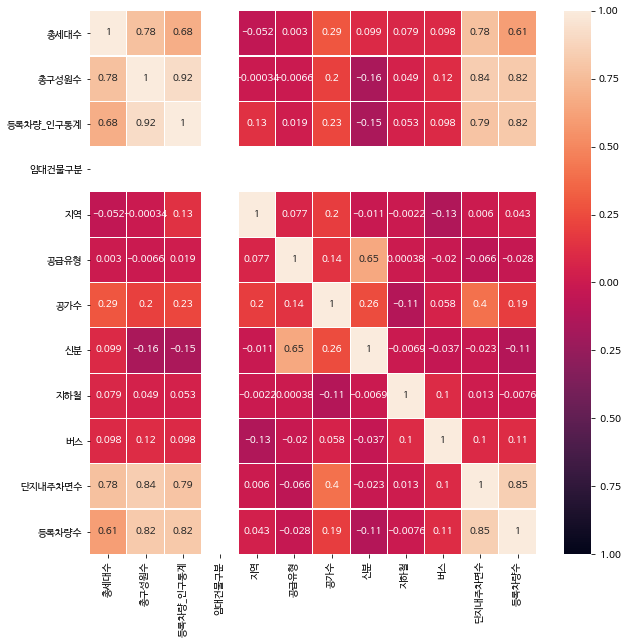

In [389]:
plt.figure(figsize=(10, 10))
sns.heatmap(new_train.corr(), vmin=-1, vmax=1, annot=True, linewidths=0.01)

In [390]:
new_train

,단지코드,총세대수,총구성원수,등록차량_인구통계,임대건물구분,지역,공급유형,공가수,신분,지하철,버스,단지내주차면수,등록차량수
0,C2515,545.0,1018.0,509.00,0.0,0.0,0.0,17.0,0.0,0.0,3.0,624.0,205.0
1,C1407,1216.0,2299.0,919.60,0.0,1.0,0.0,13.0,0.0,1.0,1.0,1285.0,1064.0
2,C1945,755.0,1979.5,989.75,0.0,2.0,0.0,6.0,1.0,1.0,3.0,734.0,730.0
3,C1470,696.0,1388.0,832.80,0.0,3.0,0.0,14.0,0.0,0.0,2.0,645.0,553.0
4,C1898,566.0,1039.5,623.70,0.0,3.0,0.0,9.0,0.0,0.0,6.0,517.0,415.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,C2586,90.0,108.0,32.40,0.0,8.0,8.0,7.0,9.0,0.0,3.0,66.0,57.0
405,C2035,492.0,750.0,375.00,0.0,4.0,0.0,24.0,0.0,0.0,1.0,521.0,246.0
406,C2020,40.0,47.5,19.00,0.0,7.0,8.0,7.0,11.0,1.0,2.0,25.0,19.0
407,C2437,90.0,90.0,45.00,0.0,10.0,2.0,12.0,2.0,0.0,1.0,30.0,16.0


In [391]:
new_test

,단지코드,총세대수,총구성원수,등록차량_인구통계,임대건물구분,지역,공급유형,공가수,신분,지하철,버스,단지내주차면수
0,C1072,754.0,1696.0,848.00,0.0,2.0,0.0,14.0,7.0,0.0,2.0,683.0
1,C1128,1354.0,2997.0,1498.50,0.0,2.0,0.0,9.0,7.0,0.0,3.0,1216.0
2,C1456,619.0,1329.0,531.60,0.0,7.0,0.0,18.0,0.0,0.0,16.0,547.0
3,C1840,593.0,1228.0,736.80,0.0,3.0,0.0,7.0,0.0,0.0,3.0,543.0
4,C1332,1297.0,2746.0,1373.00,0.0,2.0,0.0,11.0,7.0,0.0,2.0,1112.0
...,...,...,...,...,...,...,...,...,...,...,...,...
145,C2456,349.0,514.5,154.35,0.0,8.0,0.0,17.0,7.0,0.0,4.0,270.0
146,C1266,596.0,856.0,428.00,0.0,10.0,0.0,35.0,7.0,0.0,1.0,593.0
147,C2152,120.0,147.0,73.50,0.0,4.0,2.0,9.0,2.0,0.0,1.0,40.0
148,C1267,675.0,920.0,460.00,0.0,0.0,0.0,38.0,7.0,0.0,1.0,467.0


### **학습 및 추론**
--- 


In [392]:
X_train = new_train.iloc[:, 1:-1]
Y_train = new_train.iloc[:,-1]
x_test = new_test.iloc[:,1:]

In [393]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, 
                                                      random_state=seed, shuffle=True)

In [394]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(
        loss_function='MAE',
        n_estimators=500, 
        learning_rate=0.05, 
        random_state=seed     
    )
cat.fit(x_train, y_train, eval_set=(x_valid, y_valid), use_best_model=True)

0:	learn: 280.6574912	test: 262.3749989	best: 262.3749989 (0)	total: 3.06ms	remaining: 1.53s
1:	learn: 271.8593794	test: 254.7667670	best: 254.7667670 (1)	total: 5.46ms	remaining: 1.36s
2:	learn: 263.9321885	test: 247.4373476	best: 247.4373476 (2)	total: 7.78ms	remaining: 1.29s
3:	learn: 256.4288575	test: 241.6479877	best: 241.6479877 (3)	total: 10.7ms	remaining: 1.33s
4:	learn: 248.8239356	test: 235.2344349	best: 235.2344349 (4)	total: 12.6ms	remaining: 1.25s
5:	learn: 242.2822311	test: 230.2432606	best: 230.2432606 (5)	total: 14.6ms	remaining: 1.2s
6:	learn: 234.7662444	test: 224.4018188	best: 224.4018188 (6)	total: 16.6ms	remaining: 1.17s
7:	learn: 229.0927441	test: 219.5809901	best: 219.5809901 (7)	total: 18.5ms	remaining: 1.14s
8:	learn: 222.7643974	test: 213.9446120	best: 213.9446120 (8)	total: 20.3ms	remaining: 1.11s
9:	learn: 215.6905535	test: 206.9621066	best: 206.9621066 (9)	total: 22.5ms	remaining: 1.1s
10:	learn: 211.0942789	test: 203.3239705	best: 203.3239705 (10)	total: 2

In [395]:
from catboost import Pool, cv

parms = {"loss_function":'MAE',
        "n_estimators":500, 
        "learning_rate":0.05, 
        "random_state":seed}

cv(Pool(data=X_train, label=Y_train), parms, fold_count=5, plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 538.2477237	test: 538.9040938	best: 538.9040938 (0)
1:	learn: 512.5840213	test: 513.9127501	best: 513.9127501 (1)
2:	learn: 488.4584710	test: 490.2530584	best: 490.2530584 (2)
3:	learn: 465.7049334	test: 467.8974679	best: 467.8974679 (3)
4:	learn: 444.1953883	test: 446.5706743	best: 446.5706743 (4)
5:	learn: 425.0069263	test: 427.6997208	best: 427.6997208 (5)
6:	learn: 406.8037955	test: 410.1857230	best: 410.1857230 (6)
7:	learn: 389.6887934	test: 393.0792670	best: 393.0792670 (7)
8:	learn: 373.2019160	test: 377.2888072	best: 377.2888072 (8)
9:	learn: 357.3595980	test: 362.3273868	best: 362.3273868 (9)
10:	learn: 342.8178314	test: 348.1032793	best: 348.1032793 (10)
11:	learn: 329.1214769	test: 334.7958833	best: 334.7958833 (11)
12:	learn: 316.1981559	test: 322.1117181	best: 322.1117181 (12)
13:	learn: 304.8636173	test: 310.5781203	best: 310.5781203 (13)
14:	learn: 293.2611052	test: 299.0716144	best: 299.0716144 (14)
15:	learn: 282.3800000	test: 287.9927438	best: 287.9927438 (

,iterations,test-MAE-mean,test-MAE-std,train-MAE-mean,train-MAE-std
0,0,538.904094,25.469387,538.247724,6.324284
1,1,513.912750,24.861552,512.584021,6.217169
2,2,490.253058,24.604427,488.458471,5.780226
3,3,467.897468,24.196099,465.704933,5.538488
4,4,446.570674,23.328879,444.195388,5.382775
...,...,...,...,...,...
495,495,117.919544,11.612103,35.701717,2.625584
496,496,117.927281,11.624996,35.667848,2.625057
497,497,117.930077,11.627770,35.637371,2.631409
498,498,117.954938,11.625930,35.592205,2.638566


In [396]:
from sklearn.metrics import mean_absolute_error
score = mean_absolute_error(y_valid, cat.predict(x_valid))
score

98.45459712302912

In [397]:
pred = cat.predict(x_test)

In [398]:
submission['num'] = pred

In [399]:
# submission.to_csv(result_path + result_file, index=False)